In [1]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow_addons as tfa

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

/home/harvey/tf-env/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 Super, compute capability 7.5


In [2]:
records = []
from os import walk
for (dirpath, dirnames, filenames) in walk("records/"):
    for f in filenames:
        if "train" in f:
            records.append("records/{}".format(f))

print(records)

['records/train10-2071.tfrec', 'records/train12-2071.tfrec', 'records/train11-2071.tfrec', 'records/train06-2071.tfrec', 'records/train03-2071.tfrec', 'records/train02-2071.tfrec', 'records/train05-2071.tfrec', 'records/train13-2071.tfrec', 'records/train01-2071.tfrec', 'records/train15-2061.tfrec', 'records/train14-2071.tfrec', 'records/train07-2071.tfrec', 'records/train00-2071.tfrec', 'records/train08-2071.tfrec', 'records/train04-2071.tfrec', 'records/train09-2071.tfrec']


In [3]:
dataset = tf.data.TFRecordDataset(filenames = records)

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

In [5]:
IMG_SIZE = 128

@tf.function
def toPairs(inp):
    example = tf.io.parse_single_example(inp, feature_description)
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    
    label = example['target']

    return img, label

In [6]:
alldata = dataset.map(toPairs)

In [7]:
total = 33126
#for i in iter(alldata):
#    total += 1
#print("{} images in total.".format(total))

In [8]:
train = 0.66
val = 0.33

train_data = alldata.take(int(total*train))
leftover = alldata.skip(int(total*train))
val_data = leftover.take(int(total*val))

In [9]:
BATCH_SIZE = 512
train_batches = train_data.batch(BATCH_SIZE)
val_batches = val_data.batch(BATCH_SIZE)

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

Second baseline - Transfer learning from inception

In [70]:
img_in = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

features = base_model(img_in)
features = tf.keras.layers.GlobalAveragePooling2D()(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Dropout(0.3)(features)

predictor = tf.keras.layers.Dense(1, activation="sigmoid")(features)

model = tf.keras.Model(inputs=[img_in], outputs=predictor)

Precision - 
How many of the melanoma that we said are bad were actually bad?
Recall -
How many of the bad melanoma did we catch?

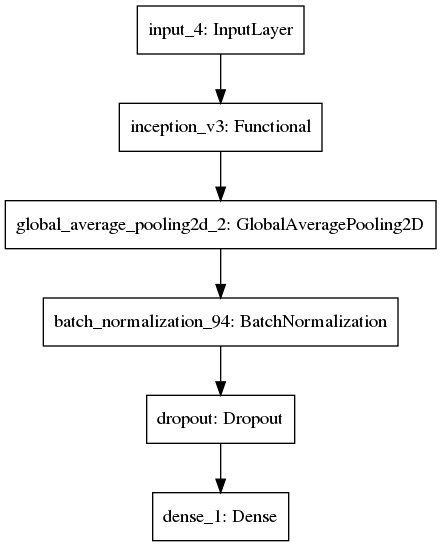

In [71]:
tf.keras.utils.plot_model(model)

In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=["AUC"])

In [84]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    verbose=1,
    mode="max",
    restore_best_weights=True
)

hist = model.fit(train_batches, validation_data=val_batches, epochs=100, callbacks=[stopper])

Epoch 1/100
43/43 [==============================] - 443s 10s/step - loss: 0.1487 - auc: 0.5668 - val_loss: 0.0827 - val_auc: 0.6474
Epoch 2/100
43/43 [==============================] - 449s 10s/step - loss: 0.0959 - auc: 0.6706 - val_loss: 0.0809 - val_auc: 0.7105
Epoch 3/100
43/43 [==============================] - 425s 10s/step - loss: 0.0879 - auc: 0.7302 - val_loss: 0.0805 - val_auc: 0.7223
Epoch 4/100
43/43 [==============================] - 424s 10s/step - loss: 0.0872 - auc: 0.7359 - val_loss: 0.0795 - val_auc: 0.7311
Epoch 5/100
43/43 [==============================] - 426s 10s/step - loss: 0.0850 - auc: 0.7550 - val_loss: 0.0799 - val_auc: 0.7355
Epoch 6/100
43/43 [==============================] - 427s 10s/step - loss: 0.0820 - auc: 0.7743 - val_loss: 0.0795 - val_auc: 0.7388
Epoch 7/100
43/43 [==============================] - 429s 10s/step - loss: 0.0814 - auc: 0.7889 - val_loss: 0.0792 - val_auc: 0.7401
Epoch 8/100
43/43 [==============================] - 428s 10s/step - 

In [85]:
test_records = []

for (dirpath, dirnames, filenames) in walk("records/"):
    for f in filenames:
        if "test" in f:
            test_records.append("records/{}".format(f))

print(test_records)

['records/test01-687.tfrec', 'records/test02-687.tfrec', 'records/test08-687.tfrec', 'records/test09-687.tfrec', 'records/test10-687.tfrec', 'records/test15-677.tfrec', 'records/test06-687.tfrec', 'records/test04-687.tfrec', 'records/test07-687.tfrec', 'records/test14-687.tfrec', 'records/test05-687.tfrec', 'records/test11-687.tfrec', 'records/test13-687.tfrec', 'records/test00-687.tfrec', 'records/test03-687.tfrec', 'records/test12-687.tfrec']


In [86]:
feature_description_test = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}

In [87]:
test_dataset = tf.data.TFRecordDataset(filenames = test_records)

In [88]:
test_names = []

for inp in test_dataset:
    example = tf.io.parse_single_example(inp, feature_description_test)
    test_names.append(example['image_name'].numpy().decode("utf_8"))

In [89]:
test_names[0]

'ISIC_5583376'

In [90]:
@tf.function
def toInput(inp):
    example = tf.io.parse_single_example(inp, feature_description_test)
        
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    return img

In [91]:
test_batches = test_dataset.map(toInput)

In [92]:
test_batches = test_batches.batch(BATCH_SIZE)

In [93]:
predictions = model.predict(test_batches)

In [99]:
import csv

i = 0

with open("submission.csv", "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["image_name", "target"])
    for p in predictions:
        prounded = f"{p[0]:.9f}"
        writer.writerow([test_names[i], prounded])
        i += 1